## Import packages & load pictures

In [80]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D


In [81]:
from google.colab import drive # Set up the path (read files in google drive)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
class_names = ['Door_number','No_number']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (64, 64)

In [83]:
def load_data():
    datasets = ['/content/drive/MyDrive/Training_data', '/content/drive/MyDrive/Testing_Data']  # Path of training folder and testing folder
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color should be RGB, default is BGR
                image = cv2.resize(image, IMAGE_SIZE)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')

        output.append((images, labels))

    return output

In [84]:
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
train_images = train_images / 255.0
test_images = test_images / 255.0
input_shape = (64, 64, 3)

Loading /content/drive/MyDrive/Training_data


100%|██████████| 50/50 [00:10<00:00,  4.63it/s]


Loading /content/drive/MyDrive/Testing_Data


100%|██████████| 11/11 [00:02<00:00,  4.85it/s]


## CNN model

In [85]:
model = Sequential([
        Conv2D(64, (3, 3), input_shape=input_shape, padding='same',
               activation='relu', strides=2),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        Conv2D(128, (3, 3), input_shape=input_shape, padding='same',
               activation='relu', strides=2),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Dropout(0.2),
        Flatten(),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Output layer，use softmax to classify
    ])
model.compile(optimizer='adam',  # SGD(lr=0.1)
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history = model.fit(train_images, train_labels,
                        # validation_data=(test_images, test_labels),
                        # verbose=2,callbacks=[earlyStop],
                        batch_size=128, epochs=10)

Epoch 1/10
1/1 [==============================] - 1s 533ms/step - loss: 0.5830 - accuracy: 0.7963
Epoch 2/10
1/1 [==============================] - 0s 111ms/step - loss: 0.3232 - accuracy: 0.9259
Epoch 3/10
1/1 [==============================] - 0s 115ms/step - loss: 0.2508 - accuracy: 0.9259
Epoch 4/10
1/1 [==============================] - 0s 101ms/step - loss: 0.2763 - accuracy: 0.9259
Epoch 5/10
1/1 [==============================] - 0s 97ms/step - loss: 0.2665 - accuracy: 0.9259
Epoch 6/10
1/1 [==============================] - 0s 109ms/step - loss: 0.3548 - accuracy: 0.9259
Epoch 7/10
1/1 [==============================] - 0s 95ms/step - loss: 0.3605 - accuracy: 0.9259
Epoch 8/10
1/1 [==============================] - 0s 100ms/step - loss: 0.3307 - accuracy: 0.9259
Epoch 9/10
1/1 [==============================] - 0s 95ms/step - loss: 0.2950 - accuracy: 0.9259
Epoch 10/10
1/1 [==============================] - 0s 108ms/step - loss: 0.2888 - accuracy: 0.9259


## Observe model's performance

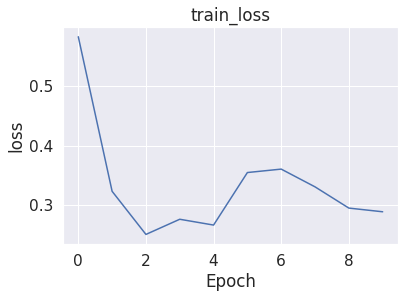

In [86]:
plt.title('train_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.plot(history.history["loss"])

In [87]:
scores = model.evaluate(test_images, test_labels)
scores

1/1 [==============================] - 0s 129ms/step - loss: 0.4369 - accuracy: 0.8462


[0.43691614270210266, 0.8461538553237915]

In [88]:
predictions = model.predict(test_images)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis=1)

## Confusion matrix & Prediction

In [89]:
CM = confusion_matrix(test_labels, pred_labels)

def accuracy(confusion_matrix):
        diagonal_sum = confusion_matrix.trace()
        sum_of_all_elements = confusion_matrix.sum()
        return diagonal_sum / sum_of_all_elements

print(accuracy(CM))

0.8461538461538461


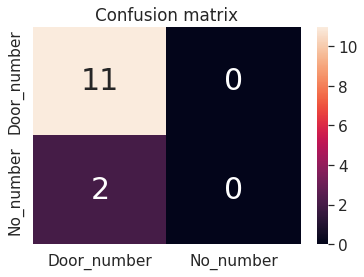

In [90]:
ax = plt.axes()
sn.heatmap(CM, annot=True,
               annot_kws={"size": 30},
               xticklabels=class_names,
               yticklabels=class_names, ax=ax)
ax.set_title('Confusion matrix')
plt.show()

##Save & Load model

In [91]:
from keras.models import load_model


In [92]:
model.save("Door_number_model") 

INFO:tensorflow:Assets written to: Door_number_model/assets


In [93]:
model = load_model('/content/Door_number_model')

## Result

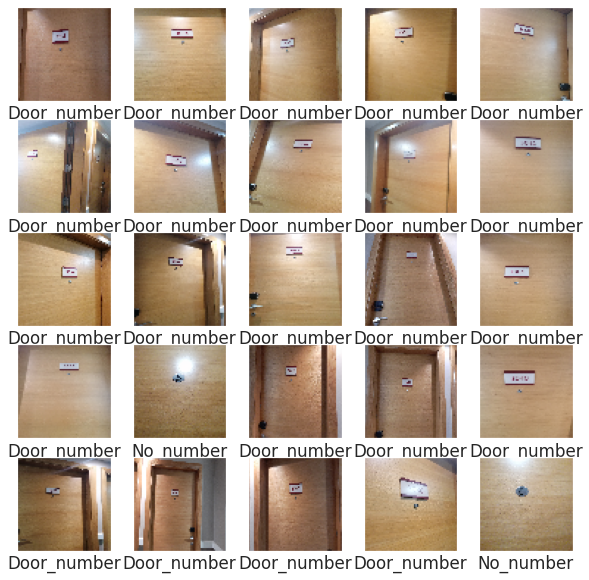

In [94]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [95]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

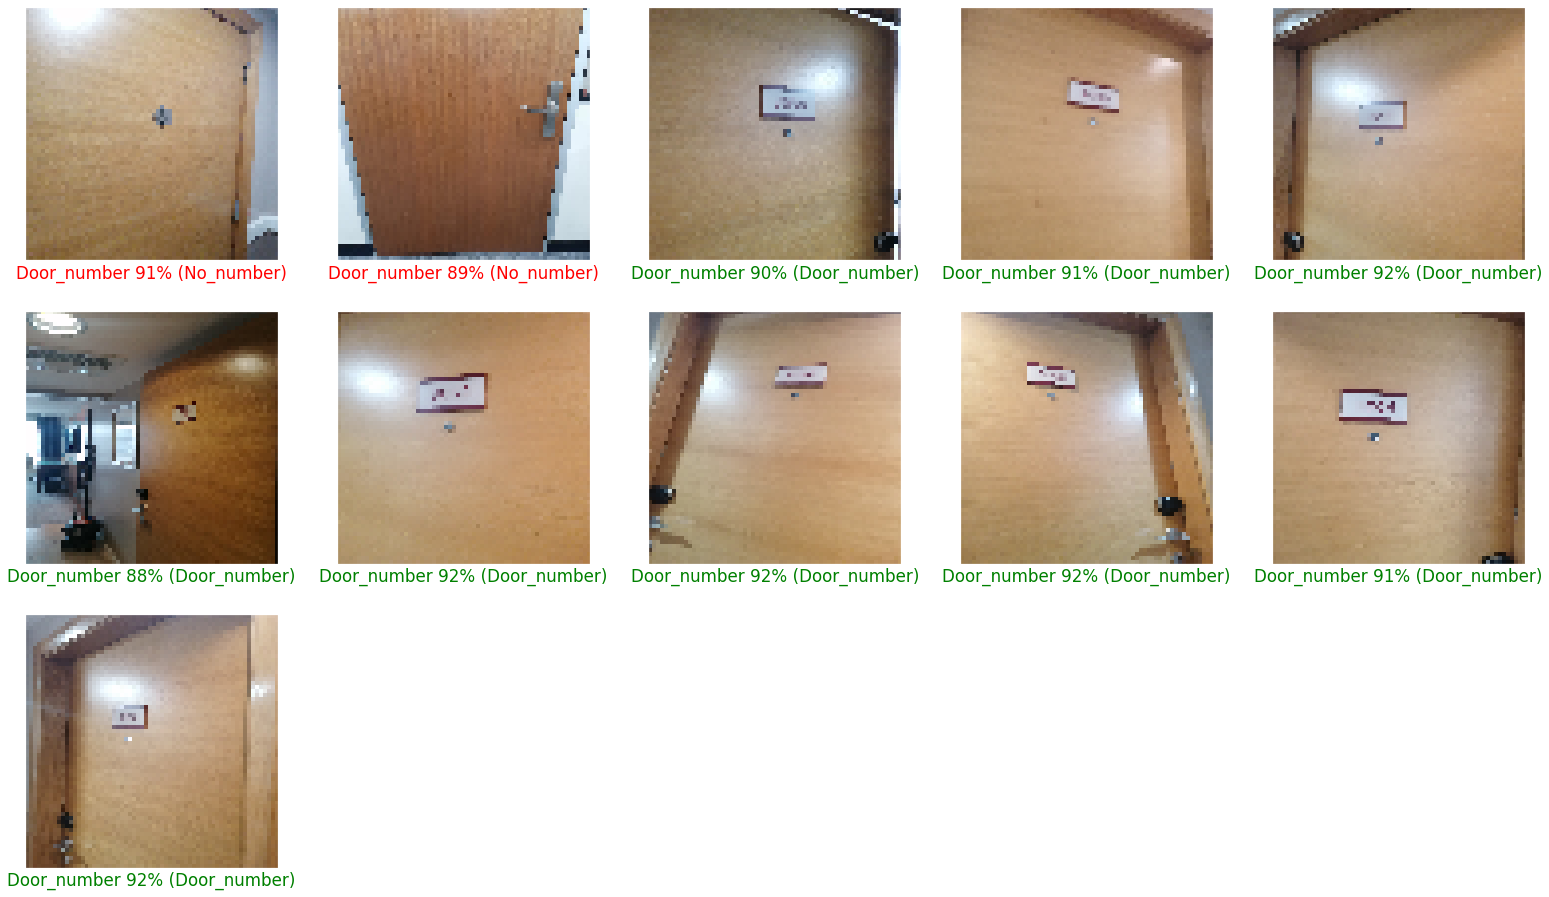

In [96]:
plt.figure(figsize=(27,27))
for i in range(0,11):
  plt.subplot(5,5,i+1)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plot_image(i, predictions, test_labels, test_images)
plt.show()

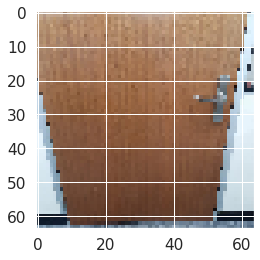

In [97]:
from keras.preprocessing import image
IMAGE_PATH='/content/drive/MyDrive/Testing_Data/No_number/zero.jpeg'
img=tf.keras.preprocessing.image.load_img(IMAGE_PATH,target_size=(64,64))
img=tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(img/255.)

In [98]:
predictions=model.predict(np.array([img]))
print('Predicted:', predictions)


Predicted: [[1. 0.]]
